# Hate Speech Classification using Deep Learning
Name: Diandra Regita Abigail Damanik

Email: diandraregita14@gmail.com

### Importing necessary libraries

In [1]:
!wget https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech/resolve/main/measuring-hate-speech.parquet

--2024-01-06 14:58:14--  https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech/resolve/main/measuring-hate-speech.parquet
Resolving huggingface.co (huggingface.co)... 18.244.202.73, 18.244.202.118, 18.244.202.60, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.73|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech/6819525ce61bc24344df9fc3f7bf48270b31038273cc27c67fc225b51433b0e1?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27measuring-hate-speech.parquet%3B+filename%3D%22measuring-hate-speech.parquet%22%3B&Expires=1704812294&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNDgxMjI5NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9kYXRhc2V0cy91Y2JlcmtlbGV5LWRsYWIvbWVhc3VyaW5nLWhhdGUtc3BlZWNoLzY4MTk1MjVjZTYxYmMyNDM0NGRmOWZjM2Y3YmY0ODI3MGIzMTAzODI3M2NjMjdjNjdmYzIyNWI1MTQzM2IwZTE%7EcmVz

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D, BatchNormalization, Dropout, GRU

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Path to the dataset in Parquet format

In [34]:
parquet_file_path = 'measuring-hate-speech.parquet'

# Read the Parquet file into a DataFrame
df = pd.read_parquet(parquet_file_path)

## Data Cleaning
1. Removing duplicate rows based on the 'text' column
2. Filtering out rows where hate_speech_score is less than 0
3. Removing rows where all columns from the second column onwards are False
4. Dropping irrelevant columns

In [35]:
df = df.drop_duplicates(subset='text')

In [36]:
# Drop rows where the value in the 'hate_speech_score' column is less than 0
condition = df['hate_speech_score'] < 0
df = df[~condition]

# Filter the DataFrame to display rows where all specified columns are False
df = df[~df[df.columns[1:]].apply(lambda row: all(row == False), axis=1)]

all_columns = df.keys()

# List of columns to be dropped
columns_to_drop = list(all_columns)[:list(all_columns).index('hate_speech_score') + 1]
columns_to_drop.extend(list(all_columns)[list(all_columns).index('infitms'):list(all_columns).index('hypothesis') + 1])
columns_to_drop.extend(list(all_columns)[list(all_columns).index('annotator_gender'):])

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

## Exploratory Data Analysis (EDA)

In [37]:
target_columns = [col for col in df.columns if col.count('_') == 1]

### Count of Unique Values in Selected Columns (Horizontal Bar Chart)
Plotting a horizontal bar chart to visualize the count of unique values in selected columns

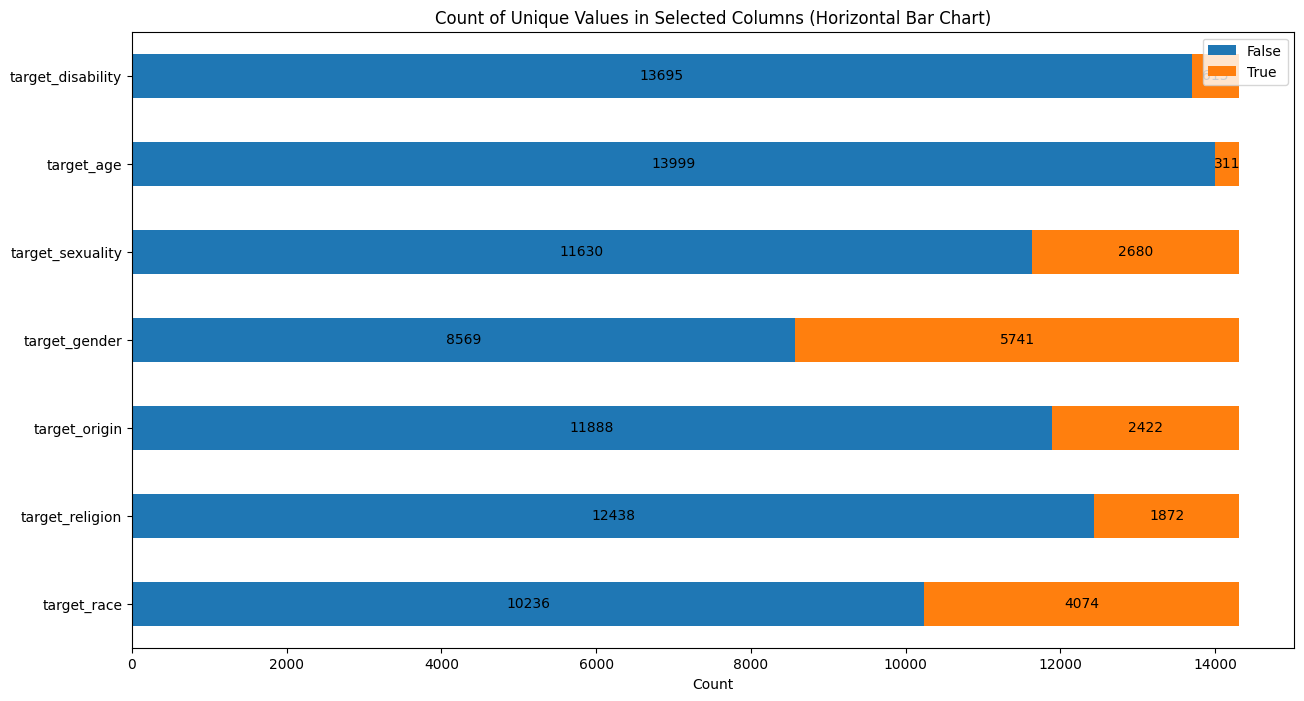

In [38]:
# Create a DataFrame with the count of each unique value in the selected columns
count_df = df[target_columns].apply(pd.value_counts).transpose()
ax = count_df.plot(kind='barh', stacked=True, figsize=(15, 8))

# Annotate each bar with its count
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{width:.0f}', (x + width/2, y + height/2), ha='center', va='center')

plt.title('Count of Unique Values in Selected Columns (Horizontal Bar Chart)')
plt.xlabel('Count')
plt.show()

In [39]:
# Drop rows that are true in two or more of the specified columns
df = df.drop(df[(df[target_columns].sum(axis=1) >= 2)].index)

### Grouping and Visualizing Columns
Grouping columns based on common prefixes and visualizing the counts

In [40]:
# Define columns in group
grouped_columns = {}
for key in target_columns:
    matching_columns = [col for col in df.columns[1:] if col.startswith(key.split('_')[0] + '_' + key.split('_')[1]) and col != key]
    grouped_columns[key] = matching_columns

In [22]:
# Function to format x-axis labels
def format_label(column_name):
    # Split the column name by underscores
    words = column_name.split('_')

    # Omit the first two words and join the rest with spaces
    formatted_label = ' '.join(words[2:])

    return formatted_label.title()

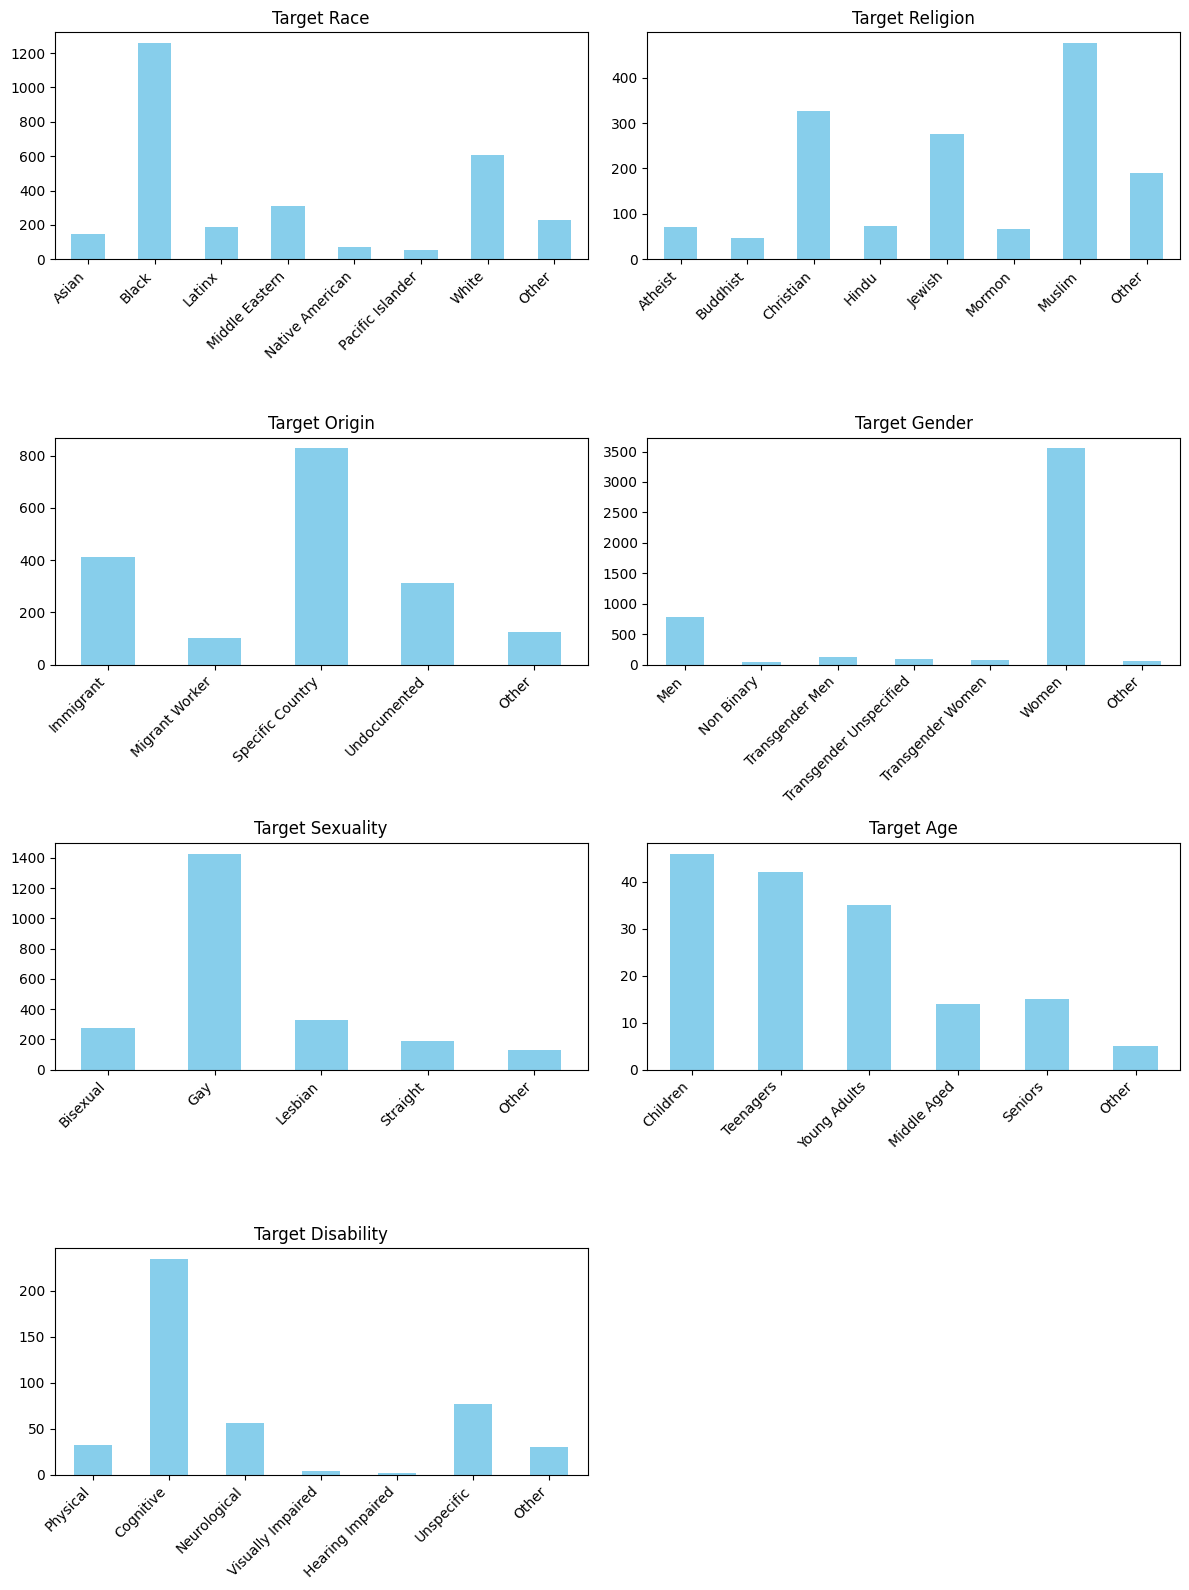

In [41]:
# Plotting settings
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
axs = axs.flatten()

for idx, (group, columns) in enumerate(grouped_columns.items()):
    df_group = df[columns]
    df_group.sum().plot(kind='bar', ax=axs[idx], color='skyblue')
    axs[idx].set_title(' '.join(group.split('_')).title())
    axs[idx].set_xticklabels([format_label(column) for column in df_group.columns], rotation=45, ha='right')

fig.delaxes(axs[-1])
plt.tight_layout()
plt.show()

## Data Cleaning Follow-Through and Transformation

### Dropping Irrelevant Columns

In [42]:
columns_to_drop = [col for col in df.columns if col.count('_') >= 2]
df = df.drop(columns=columns_to_drop)

Merging Columns and Label Encoding

In [43]:
def merge_columns(row):
    true_columns = [col for col in row.index[1:] if row[col]]
    return ', '.join(true_columns) if true_columns else 'None'

# Create a new 'merged_target' column
df['merged_target'] = df.apply(merge_columns, axis=1)

# Drop the original target columns
df = df[df['merged_target'] != 'None'].drop(columns=target_columns)

In [45]:
df['merged_target'].value_counts()

target_gender        4334
target_race          2434
target_sexuality     1714
target_origin        1372
target_religion      1197
target_disability     383
target_age            105
Name: merged_target, dtype: int64

In [46]:
# Create a LabelEncoder
label_encoder = LabelEncoder()

df['merged_target'] = label_encoder.fit_transform(df['merged_target'])

In [47]:
df['merged_target'].value_counts()

2    4334
4    2434
6    1714
3    1372
5    1197
1     383
0     105
Name: merged_target, dtype: int64

## Preprocessing

Function to clean and preprocess text data

In [51]:
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove emojis
    text = re.sub(r'\bURL\b', '', text, flags=re.IGNORECASE)  # Remove 'URL' word
    text = re.sub(r'@\w+', '', text)  # Remove accounts starting with '@'
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    tokens = word_tokenize(text)  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Remove stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]
    tokens = [word for word in tokens if not word.startswith('#')]  # Remove hashtags starting with '#'
    return ' '.join(tokens).lower()

In [52]:
df['text'] = df['text'].apply(clean_text)

## Data Resampling for Class Balance
Oversampling to balance class distribution

In [ ]:
majority_class = df['merged_target'].value_counts().idxmax()

# Set the target count to match the majority class count
target_count = df['merged_target'].value_counts().max()

# Oversample minority classes to match the majority class count
oversampled_df = pd.DataFrame()

for class_label, group in df.groupby('merged_target'):
    if class_label == majority_class:
        oversampled_df = oversampled_df.append(group)
    else:
        oversampled_group = resample(group, replace=True, n_samples=target_count, random_state=42)
        oversampled_df = pd.concat([oversampled_df, oversampled_group])

# Shuffle the DataFrame
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [58]:
oversampled_df['merged_target'].value_counts()

0    4334
1    4334
2    4334
3    4334
4    4334
5    4334
6    4334
Name: merged_target, dtype: int64

## Tokenization and Model Building

In [95]:
texts = oversampled_df['text'].values
labels = oversampled_df['merged_target'].values

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_len = 100  # Set the desired sequence length
train_data = pad_sequences(train_sequences, maxlen=max_len)
test_data = pad_sequences(test_sequences, maxlen=max_len)

### Defining the LSTM-based model architecture

In [96]:
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(units=100),
    Dense(units=128, activation='relu'),
    Dense(units=7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training the model

Setting up early stopping for training

In [91]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_data, train_labels, epochs=20, validation_split=0.2, callbacks=[early_stop])

Epoch 1/20
607/607 [==============================] - 67s 104ms/step - loss: 0.8668 - accuracy: 0.6760 - val_loss: 0.3686 - val_accuracy: 0.8871
Epoch 2/20
607/607 [==============================] - 63s 103ms/step - loss: 0.1980 - accuracy: 0.9421 - val_loss: 0.2518 - val_accuracy: 0.9269
Epoch 3/20
607/607 [==============================] - 62s 101ms/step - loss: 0.0873 - accuracy: 0.9761 - val_loss: 0.2533 - val_accuracy: 0.9308
Epoch 4/20
607/607 [==============================] - 62s 102ms/step - loss: 0.0469 - accuracy: 0.9875 - val_loss: 0.2592 - val_accuracy: 0.9396
Epoch 5/20
607/607 [==============================] - 62s 102ms/step - loss: 0.0260 - accuracy: 0.9929 - val_loss: 0.3136 - val_accuracy: 0.9293


## Model Evaluation and Visualization

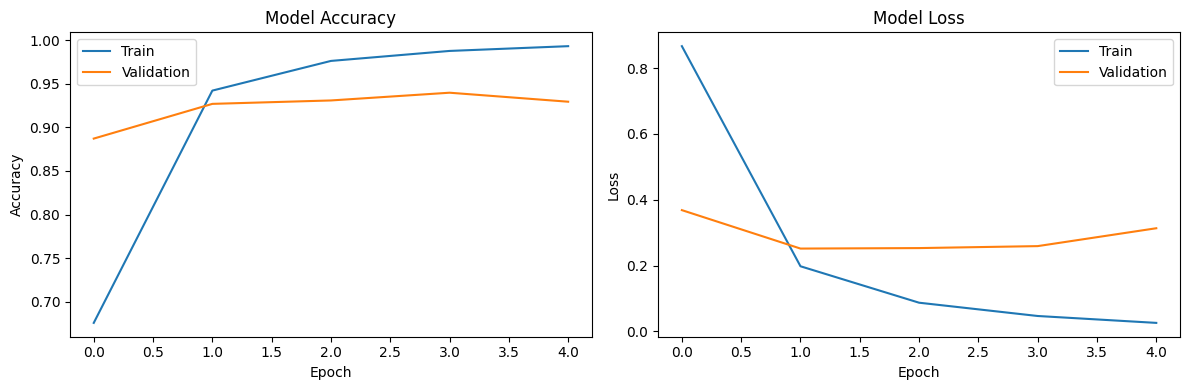

In [92]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [93]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


190/190 [==============================] - 8s 42ms/step - loss: 0.2305 - accuracy: 0.9352
Test Accuracy: 93.52%
